In [20]:
import pandas as pd
import numpy as np
import networkx as nx

In [21]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [77]:
data = 'data/conspiracy_theory_edgelist.csv'

df = pd.read_csv(data)
df.head()

,source,target
0,conspiracy theory,Conspiracy theory
1,conspiracy theory,List of conspiracy theories
2,conspiracy theory,Pizzagate conspiracy theory
3,conspiracy theory,Chemtrail conspiracy theory
4,conspiracy theory,Reptilian conspiracy theory


In [94]:
drop_nodes = ['conspiracy theory', 'deep state', 'qanon'] # drop the search strings; they aren't pages

G = nx.from_pandas_edgelist(df)
G.remove_nodes_from(drop_nodes)
G.remove_edges_from(nx.selfloop_edges(G))

# Centralities

Identify the central junk and remove it.

In [95]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
John F. Kennedy assassination conspiracy theories,0.000958
Pizzagate conspiracy theory,0.000855
List of conspiracy theories,0.000802
QAnon,0.000660
Reptilian conspiracy theory,0.000654
Fox News,0.000609
Watkins (surname),0.000596
9/11 conspiracy theories,0.000594
Sound of Freedom (film),0.000592
Dead Internet theory,0.000591


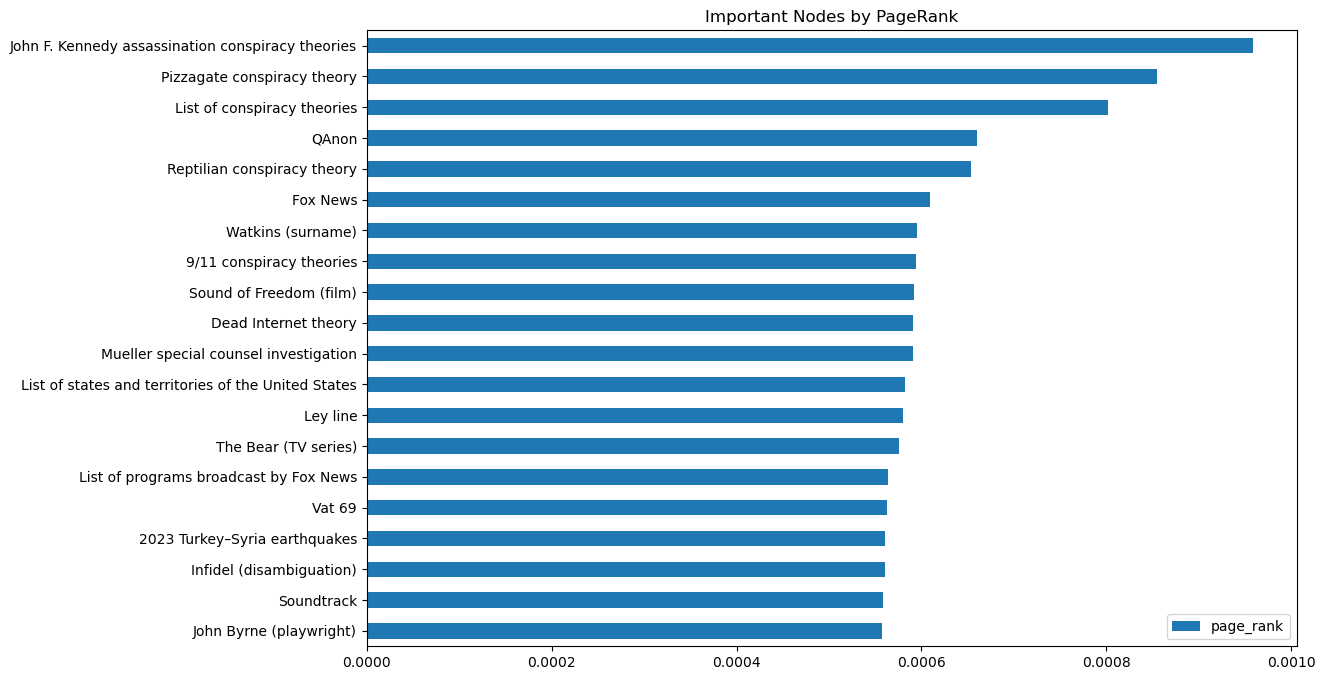

In [96]:
title = 'Important Nodes by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

In [97]:
ego = nx.ego_graph(G, 'QAnon', radius=2, center=False) # split it into cliques

In [98]:
print(ego) # QAnon network
print(G) # Full conspiracy network

Graph with 210 nodes and 547 edges
Graph with 8982 nodes and 11537 edges


# Keep it Tight
Let's keep this tight and use QAnon as the starting point. We will use the QAnon ego network as our graph for analysis. Let's restart from here, using the QAnon network as G, then doing centralities and community detection to look closer.

In [99]:
G = ego.copy()

In [100]:
print(G) # Full conspiracy network

Graph with 210 nodes and 547 edges


In [101]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Pizzagate conspiracy theory,0.024867
List of conspiracy theories,0.021233
Ron Watkins,0.018227
Sound of Freedom (film),0.017945
Reptilian conspiracy theory,0.017678
John F. Kennedy assassination conspiracy theories,0.016925
Cullen Hoback,0.015224
Q Into the Storm,0.015109
Michael Flynn,0.014256
Jim Caviezel,0.014007


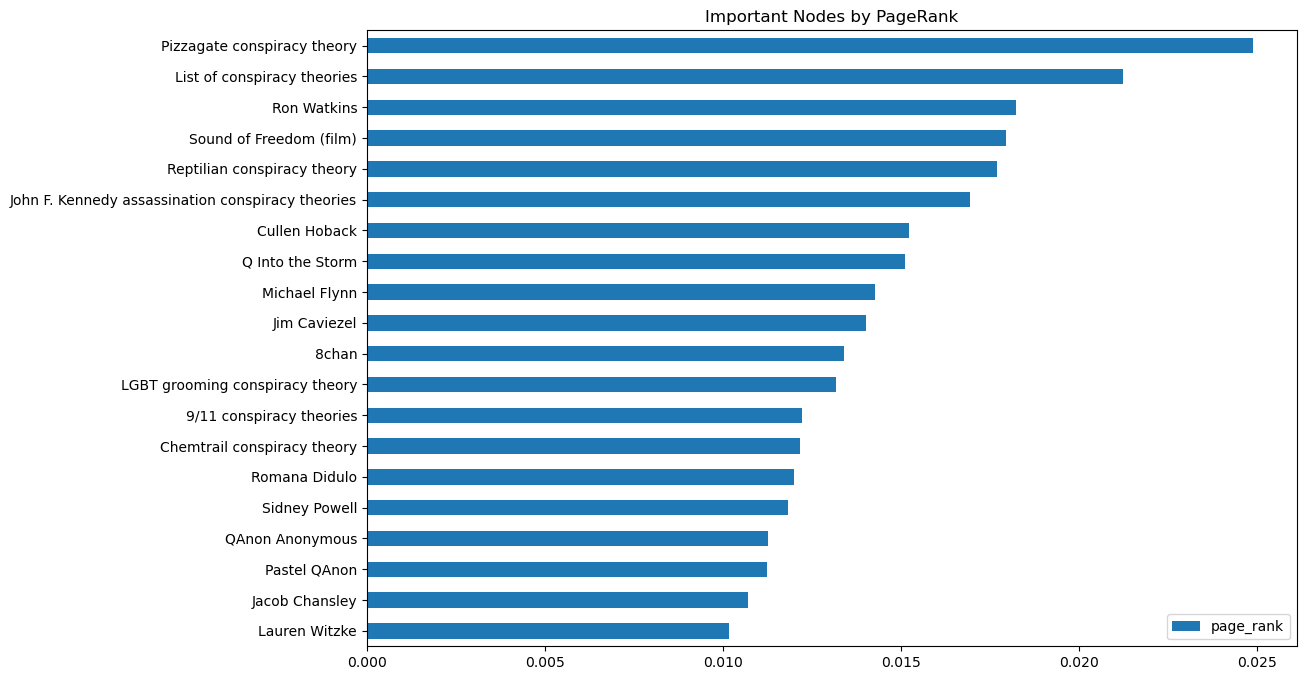

In [102]:
title = 'Important Nodes by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

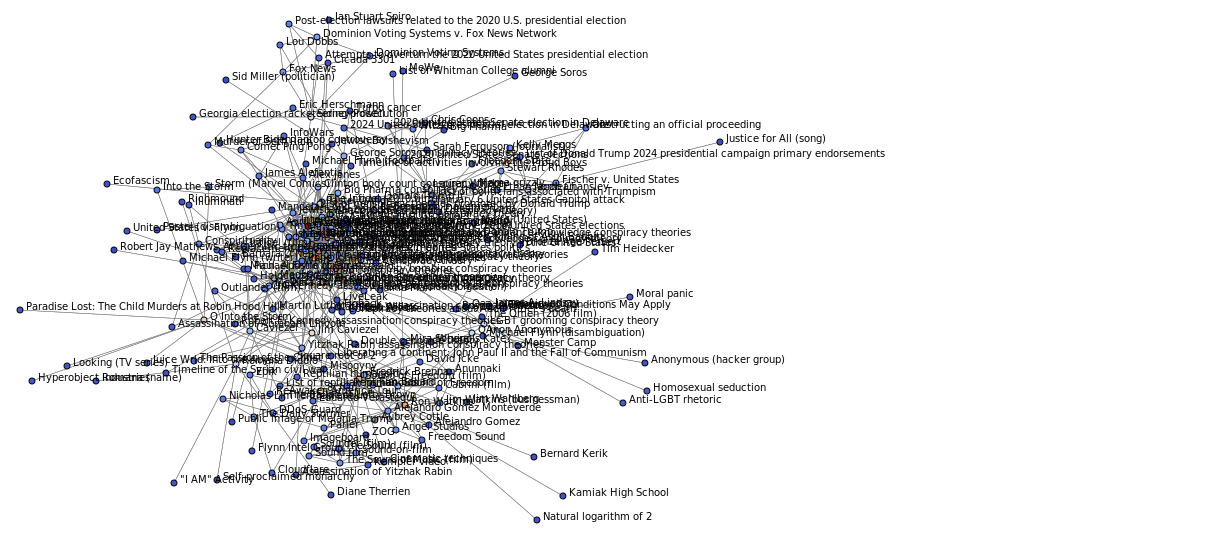

In [103]:
draw_graph(G, show_names=True, node_size=3)

# Community Detection

It's a mess, as any sufficiently complicated network is at first. Community detection will split this into pieces we can analyze separately, easily.

In [104]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=1, random_state=1337) 

In [105]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

community
0    40
1    35
6    28
8    25
4    20
2    18
7    17
5    16
3     6
9     5
Name: count, dtype: int64

In [106]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([0, 1, 6, 8, 4, 2, 7, 5, 3, 9], dtype=int64)

nodes: ['9/11 conspiracy theories', 'Avril Lavigne replacement conspiracy theory', "Barbara O'Neill", 'Big Pharma', 'Big Pharma conspiracy theories', 'Black Knight satellite conspiracy theory', 'Chemtrail conspiracy theory', 'Clinton body count conspiracy theory', "Conspiracy theories about Adolf Hitler's death", 'Conspiracy theories in United States politics', 'Conspiracy theories in the Arab world', 'Conspiracy theory', 'Dead Internet theory', 'Die Glocke (conspiracy theory)', 'Double genocide theory', 'Eurabia conspiracy theory', 'FEMA camps conspiracy theory', 'Great Replacement conspiracy theory in the United States', 'Ian Stuart Spiro', 'Israel-related animal conspiracy theories', 'Jesuit conspiracy theories', 'John F. Kennedy assassination conspiracy theories', 'LGBT chemicals conspiracy theory', 'List of conspiracy theories', 'Masonic conspiracy theories', 'Melania Trump replacement conspiracy theory', 'Oklahoma City bombing conspiracy theories', 'Opinion polls about 9/11 consp

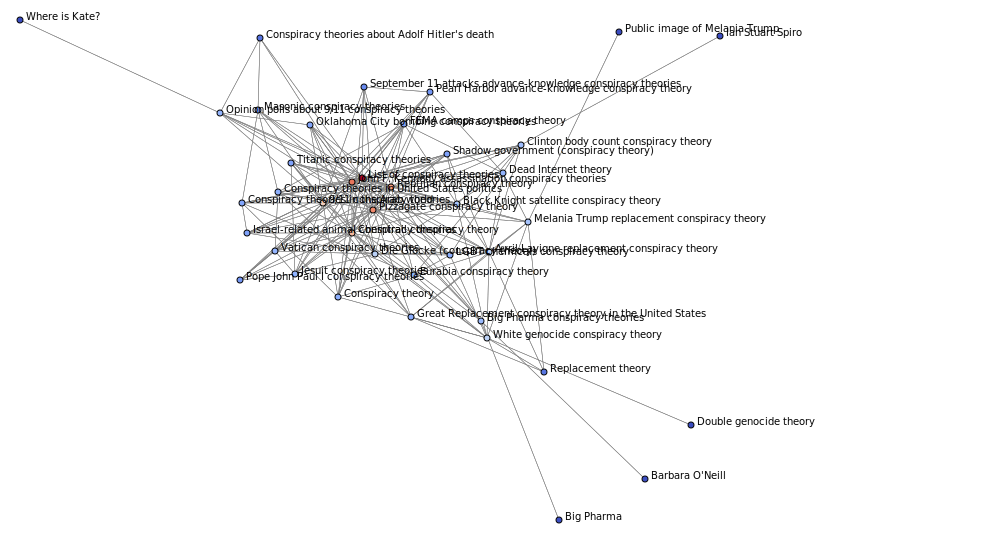

In [109]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['8chan', 'Anonymous (hacker group)', 'Aubrey Cottle', 'Bernard Kerik', 'Cloudflare', 'Cullen Hoback', 'DDoS-Guard', 'Epik', 'Fredrick Brennan', 'Freedom State', 'Hoback', 'Hyperobject Industries', 'Imageboard', 'Into the Storm', 'Jim Watkins (businessman)', 'Juice Wrld: Into the Abyss', 'Kamiak High School', 'List of Whitman College alumni', 'LiveLeak', 'Looking (TV series)', 'MeWe', 'Monster Camp', 'Natural logarithm of 2', 'Nicholas Lim (entrepreneur)', 'Paradise Lost: The Child Murders at Robin Hood Hills', 'Parler', 'Q Into the Storm', 'QAnon Anonymous', 'Qaa (disambiguation)', 'Ron Watkins', 'Square root of 2', 'Storm (Marvel Comics)', 'Terms and Conditions May Apply', 'The Daily Stormer', 'Tim Heidecker']


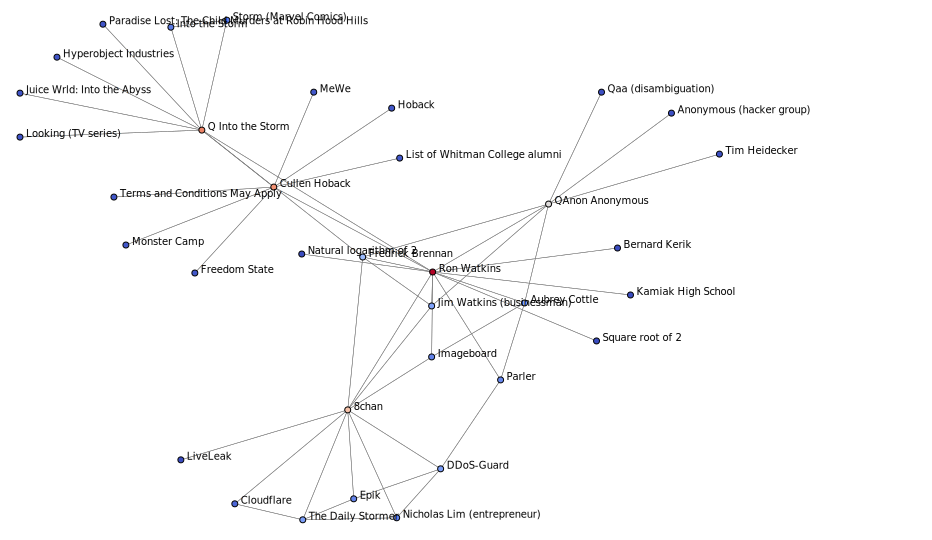

In [110]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Alejandro Gomez', 'Alejandro Gómez Monteverde', 'Angel Studios', 'Cabrini (film)', 'Caviezel', 'Cinematic techniques', 'Eduardo Verástegui', 'Freedom Sound', 'Infidel (film)', 'Jim Caviezel', 'Jim Wahlberg', 'Liberating a Continent: John Paul II and the Fall of Communism', 'Mandela: Long Walk to Freedom', 'Mira Sorvino', 'Outlander (film)', 'Paul, Apostle of Christ', 'Sound film', 'Sound of Freedom', 'Sound of Freedom (film)', 'Sound-on-film', 'Sounder (film)', 'The Ballad of Lefty Brown', 'The Infidel (2010 film)', 'The Omen (2006 film)', 'The Passion of the Christ', 'The Sound (film)', 'The Sound of Music (film)', 'Tim Ballard']


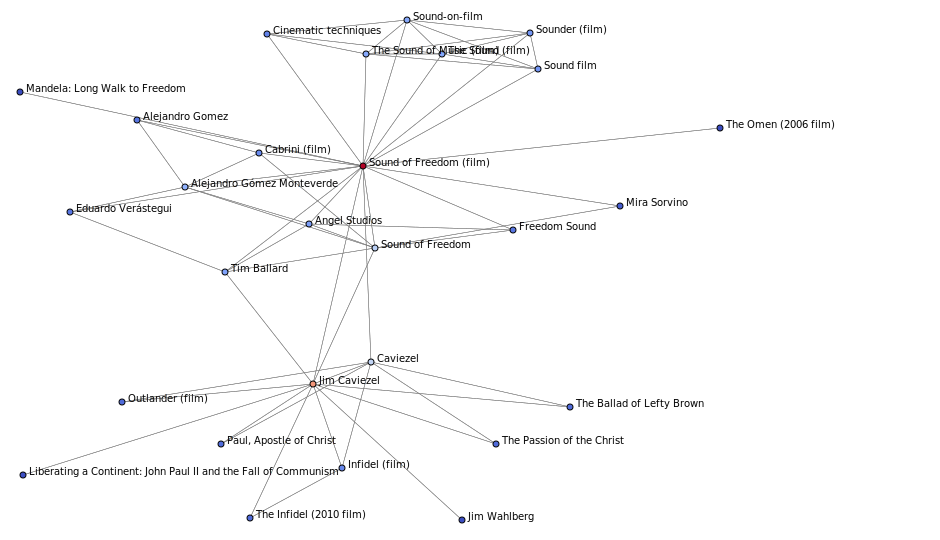

In [111]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['2020 United States Senate election in Delaware', '2020 United States Senate elections', '2024 United States presidential election in Delaware', 'Bronze Age Pervert', 'Chris Coons', 'Donald Trump', 'Donald Trump Jr.', 'Eric Herschmann', 'False or misleading statements by Donald Trump', 'Flynn Intel Group', 'Hunter Biden laptop controversy', 'Lauren Witzke', 'List of Donald Trump 2024 presidential campaign primary endorsements', 'List of conspiracy theories promoted by Donald Trump', 'List of politicians associated with Trumpism', 'Michael Flynn', 'Michael Flynn (businessman)', 'Michael Flynn (disambiguation)', 'Michael Flynn (footballer)', 'Michael Flynn (writer)', 'ReAwaken America Tour', 'Stew Peters', 'Timeline of Russian interference in the 2016 United States elections', 'United States v. Flynn', 'Witzke']


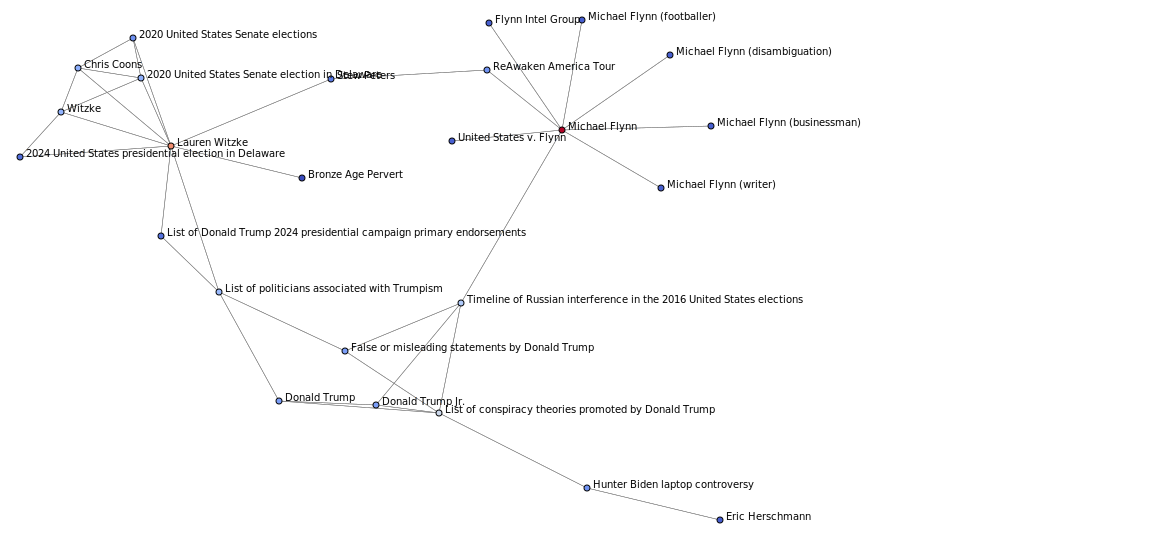

In [114]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Antifa (United States)', 'Cicada 3301', 'Ecofascism', 'Ethan Nordean', 'Fischer v. United States', 'Jacob Chansley', 'January 6 United States Capitol attack', 'Justice for All (song)', 'Kathleen Willey', 'Kelly Meggs', 'Killing of Ashli Babbitt', 'Mama grizzly', 'Obstructing an official proceeding', 'Pastel (disambiguation)', 'Pastel QAnon', 'Royce Lamberth', 'Stewart Rhodes', 'Timeline of activities involving the Proud Boys', 'Timeline of incidents involving QAnon', 'Timeline of the Syrian civil war']


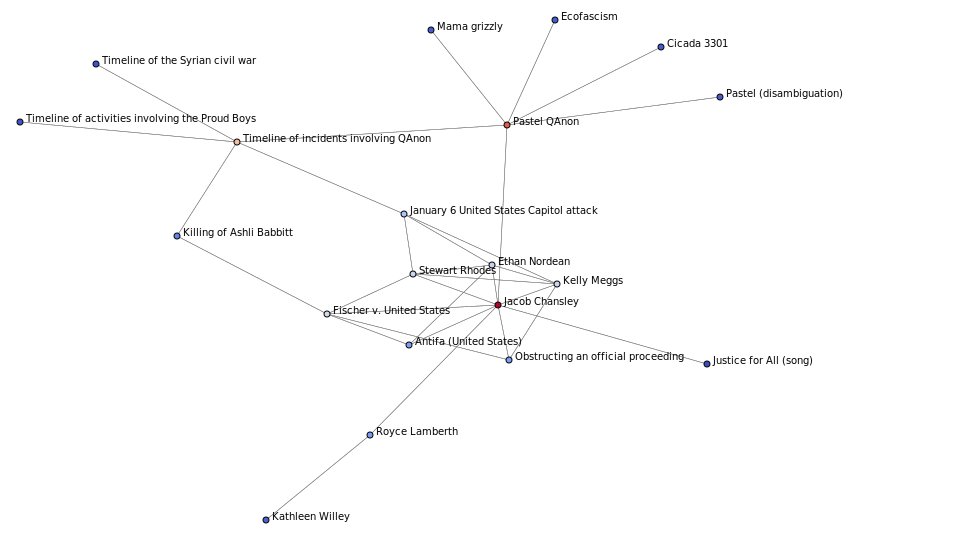

In [116]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Anti-LGBT rhetoric', 'Antisemitic trope', 'Cultural Marxism conspiracy theory', 'Gays Against Groomers', 'Groom (disambiguation)', 'Homosexual seduction', 'International Jewish conspiracy', 'James A. Lindsay', 'Jewish Bolshevism', 'Jewish war conspiracy theory', 'Judeo-Masonic conspiracy theory', 'LGBT grooming conspiracy theory', 'Misogyny', 'Moral panic', 'New World Order (conspiracy theory)', 'Robert Jay Mathews', 'ZOG', 'Zionist Occupation Government conspiracy theory']


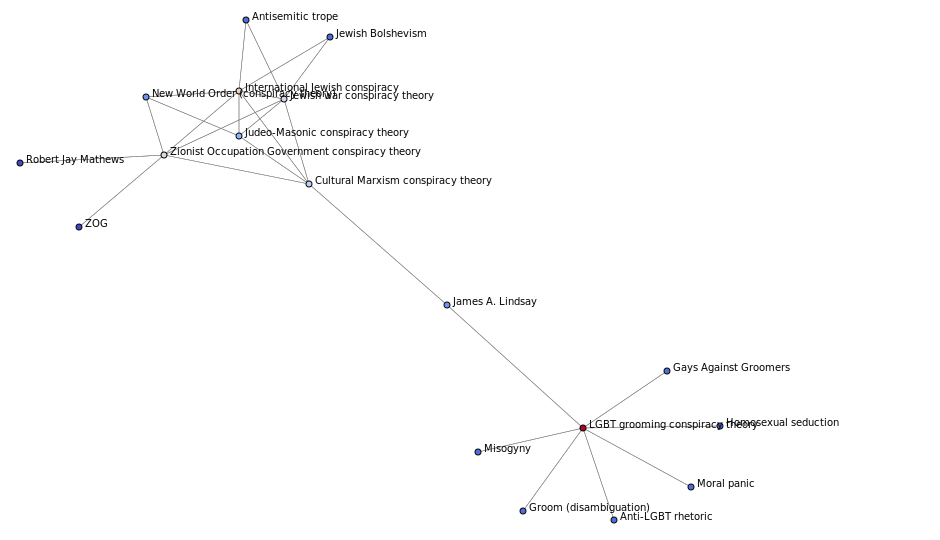

In [117]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Alex Jones', 'Attempts to overturn the 2020 United States presidential election', 'Comet Ping Pong', 'Dominion Voting Systems', 'Dominion Voting Systems v. Fox News Network', 'Fox News', 'George Soros', 'George Soros conspiracy theories', 'Georgia election racketeering prosecution', 'InfoWars', 'James Alefantis', 'Lou Dobbs', 'Murder of Seth Rich', 'Post-election lawsuits related to the 2020 U.S. presidential election', 'Sarah Ferguson (journalist)', 'Sid Miller (politician)', 'Sidney Powell']


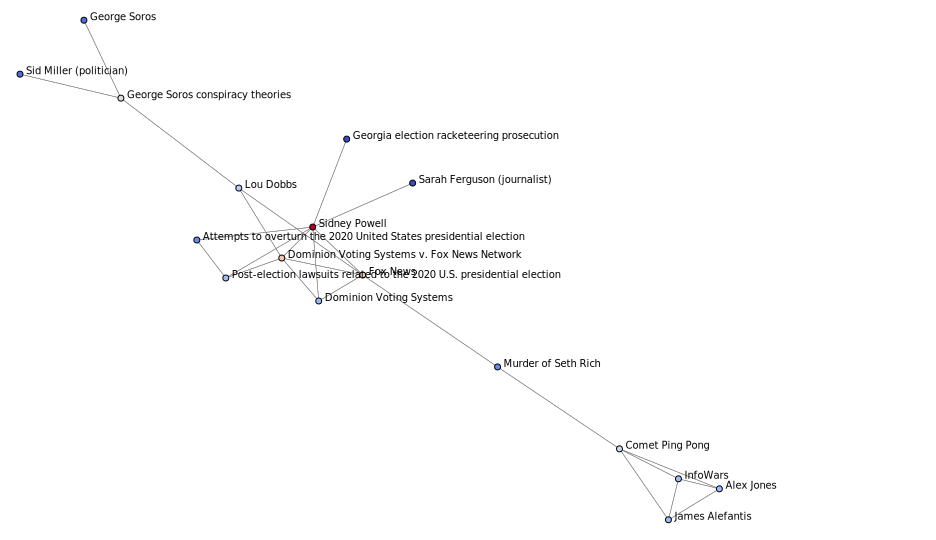

In [118]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['"I AM" Activity', 'Andinia Plan', 'Assassination of Abraham Lincoln', 'Bohemian Grove', 'Conspirituality', 'Diane Therrien', 'Holocaust denial', 'Illuminati', 'Medbed', 'Redemption movement', 'Richmound', 'Romana (name)', 'Romana Didulo', 'Self-proclaimed monarchy', 'Sovereign citizen movement', 'Turbo cancer']


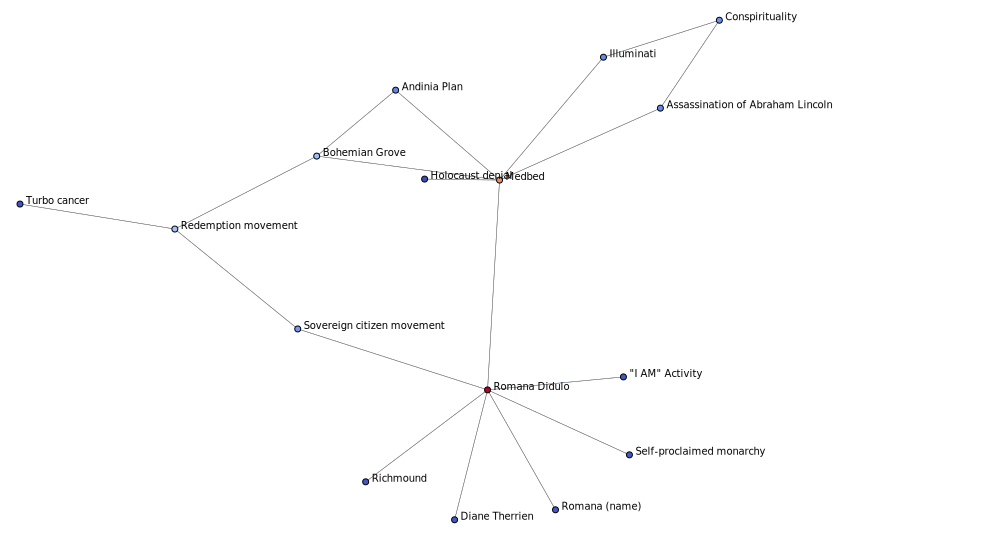

In [119]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Assassination of Yitzhak Rabin', 'CIA Kennedy assassination conspiracy theory', 'Kempler video', 'Martin Luther King Jr. assassination conspiracy theories', 'Robert F. Kennedy assassination conspiracy theories', 'Yitzhak Rabin assassination conspiracy theories']


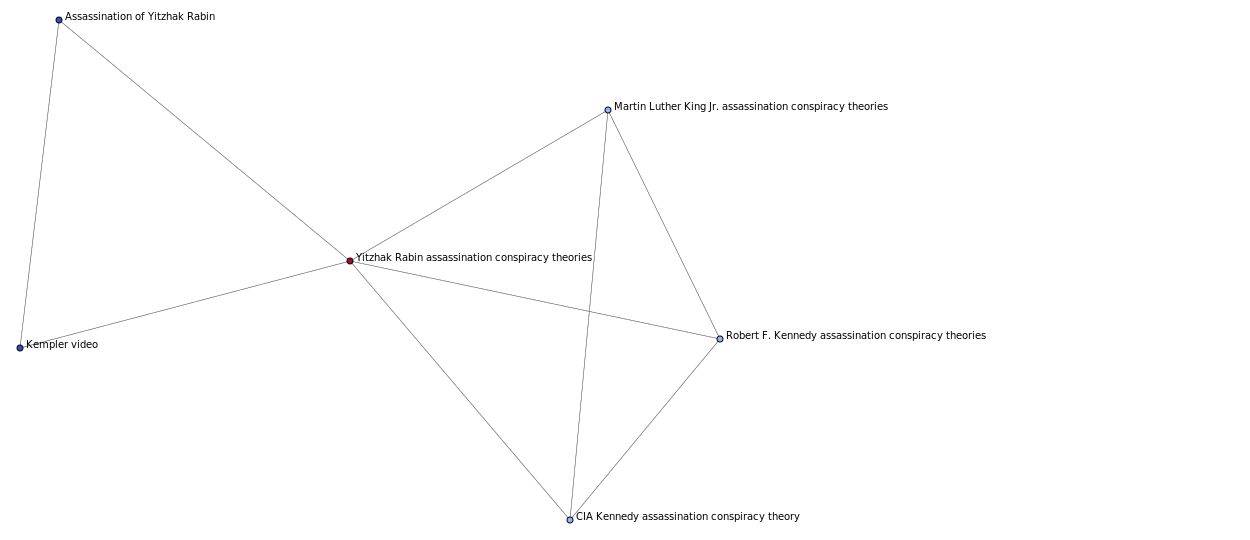

In [120]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)

nodes: ['Anunnaki', 'David Icke', 'List of reptilian humanoids', 'Reptilian', 'Reptilian humanoid']


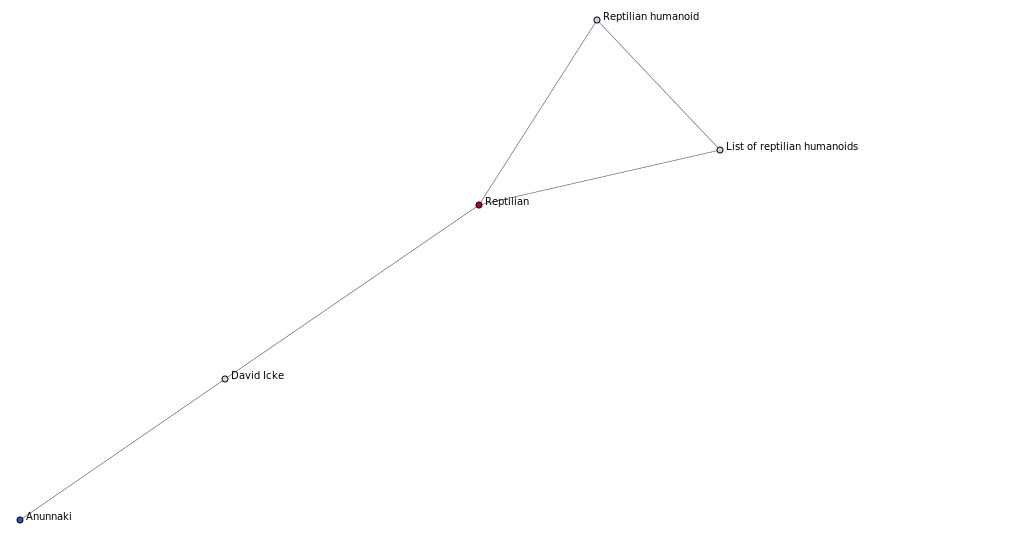

In [121]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

print('nodes: {}'.format(sorted(nodes)))
draw_graph(G_comm, show_names=True, node_size=3)